# Shift Handover

There's a project to develop a new and improved application for handling shift handover between day and night shifts offshore. The main objective is to overhaul the current solution (eLog/eLogbook) with focus on new design, enhanced user friendliness and integrations with other applications/systems. The main parts of the application are a shift log and the handover itself, where the shift log will be a log of events that have happened during the shift and the handover will include events that are deemed relevant for the next shift to have knowledge about. There's an ambition to add auto-generation of relevant events in the log based on inputs/events from the control systems, which should be found in CDF once the Digital Foundation is up an running. This notebook is made to map relevant events that are accessible through CDF.

Config/libraries:

In [4]:
import math, csv, re, datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from getpass import getpass                # Allows for an entry field to avoid hard-coded API keys
from cognite.client import CogniteClient   # Python SDK
from cognite.client.data_classes.assets import AssetList
from cognite.client.data_classes.events import EventList
from cognite.client.utils import timestamp_to_ms, ms_to_datetime

from initialize import initialize_client
# %matplotlib widget

Setup of Cognite SDK for communication with CDF (will ask for API-key):

In [5]:
client = initialize_client(False, True)

Statics:

In [6]:
class Alarm:
    def __init__(self, alarm_id, new_state = None, alarm_state = None):
        self.id = alarm_id
        self.new_state = new_state
        self.alarm_state = alarm_state


class Component:
    def __init__(self, name, area, eq_group, desc, alt_name=None):
        self.name = name
        self.area = area
        self.equipment_group = eq_group
        self.description = desc
        self.assets = None
        self.exact_match = False
        self.alt_name = alt_name


class HandoverAsset:
    def __init__(self, asset, exact_match):
        self.name = asset.name
        self.parent = asset
        self.events = EventList([])
        # If asset has a state subtag (e.g. a running or open status: ..._31 or ...-31)
        self.state_subtag = asset.name[-2:] if re.search(f'[-_][0-9][0-9]$', asset.name) else None
        self.exact_match = exact_match
            

class Field:
    def __init__(self, name, data_set_id=None):
        self.name = name
        self.data_set_id = data_set_id
        self.assets = None
        self.main_components = None

    def abbr(self):
        return {
            'Alvheim': 'ALV',
            'Ivar Aasen': 'IAA',
            'Skarv': 'SKA',
            'Ula': 'ULA',
            'Valhall': 'VAL'
        }[self.name]


class Project:
    def __init__(self, name):
        self.name = name
        self.fields = {}
        self.main_components = {}

    def append_field(self, name):
        self.fields.update({{
                'Alvheim': 'ALV',
                'Ivar Aasen': 'IAA',
                'Skarv': 'SKA',
                'Ula': 'ULA',
                'Valhall': 'VAL'
            }[name]: Field(name)
        })

    def data_sets(self):
        sets = []
        for field in self.fields.values():
            if field.data_set_id:
                sets.append(field.data_set_id)
        return sets


handover = Project("Shift Handover")
handover.append_field('Alvheim')
handover.append_field('Ivar Aasen')
handover.append_field('Skarv')
handover.append_field('Ula')
handover.append_field('Valhall')

#### Find the SAP Functional Location for the source of an event

In [10]:
# This function retrieves a CDF event by its event id
def get_event(id):
    return client.events.retrieve(id=id)

# This function retrieves a CDF asset by its asset id
def get_asset(id):
    return client.assets.retrieve(id=id)

In [13]:
get_asset(id=361499351463819)

,value
external_id,opcua_val_eo:s=fc06e8a6-abaa-4335-9b55-1367df7...
name,23-KA-9103-M01_CB_travel_alarm
parent_id,8571004476315909
parent_external_id,VAL_23-KA-9103
description,PH MV-COMP.M. FEEDER/ CB_travel_alarm
data_set_id,140572846698809
source,OPC_UA
id,361499351463819
created_time,1635296036629
last_updated_time,1685557032173


In [5]:
# This function extracts tag names from a text string
# Inputs:
# string - text string (e.g. '23-KA-9103-M01_CB_travel_alarm')
# field - all caps abbreviation of an Aker BP asset (e.g. 'VAL')
#
# Output: 
# list of found tag names in string, matching the given fields tagging convention
# (e.g. ['23-KA-9103'])

def extract_tag_names(string, field):
    def default(string, field):
        print(f"There is no function for extracting tags for {field}")
        return None
    
    # Ula tags usually follow this format: A(AAA)-NNNN(N)(A)-(A)
    def extract_ula_tag(string, field):
        return re.search(r'[A-Z]+-\d+([A-Z][A-Z]?|(-[A-Z]\b)?)', string)
    
    # Valhall tags usually follow this format: NN-AA(A)-NNNN(NN)(A)
    def extract_valhall_tag(string, field):
        return re.search('[0-9][0-9]-[A-Z]+-\d+[A-Z]?[A-Z]?', string)
    
    switcher = {
        'ULA': extract_ula_tag,
        'VAL': extract_valhall_tag
    }
    
    x = re.split('_', string)
    matches = []
    for word in x:
        y = switcher.get(field, default)(word, field)
        if y: 
            matches.append(y.group())
    if not matches: print(f'Could not identify any tags with {field} tagging convention in "{string}"')
    
    return matches

In [7]:
# NOTE: Running this cell will not work before main_components is built from a cell below
for comp in handover.main_components['VAL'][:10]:
    for asset in comp.assets[:1]:
        res = extract_tag_names(asset.name, 'VAL')
        if res: print(f'{res} <- {asset.name}')

KeyError: 'VAL'

In [6]:
# This function looks for the field (Aker BP asset) of a CDF asset
def get_field_from_asset(asset):
    # The root asset usually holds information about the Aker BP installation
    root_asset = get_asset(asset.root_id)
    installation = root_asset.name
    
    if installation in ['VAL', 'VFN', 'VFS', 'VFW', 'HOD', 'HOP', 'VLA']:
        return 'VAL'
    elif installation in ['ULA', 'TAM']:
        return 'ULA'
    elif installation in ['SKA', 'ALV', 'IAA']:
        return installation
    
    print(f'Found unexpected field from root asset: {installation}')
    return installation

In [7]:
# This function recursively searches for a parent asset of an event that is not an asset created by e.g. signal tags/subtags/softtags/etc.
# 
# Example hierarchy:
# Z-0501 (id: 8289785573229588)          <-- True parent
#  LP-0561 (id: 4103300555352816)        <-- Some other ancestor (tag does not match)
#    Z-0501-01 (id: 6791812333680596)    <-- Grandparent that comes from Aveva (still has signal tag)
#      Z-0501-01 (id: 4728001758341600)  <-- Parent asset in OPC UA dataset (has signal tag)
#        (event) Abnormal condition (source: Z-0501-01, id: 7491014714576560)

def get_true_parent(event, print_hierarchy = False):
    parent = None
    source_name = event.metadata["source"]
    
    # Store order of hierarchy for printing and troubleshooting purposes
    hierarchy = [[f'(event) {event.description} (source: {source_name}, id: {event.id})'] for _ in range(len(event.asset_ids))]
    
    # Loop through all related CDF assets for the given event
    for i, asset_id in enumerate(event.asset_ids):
        temp_asset = get_asset(asset_id)
        
        # List of potential tag names following the given fields tagging convention, usually just one
        tag_names = extract_tag_names(source_name, get_field_from_asset(temp_asset))   
        
        # Recursively search for a parent asset that matches with the desired tag name (up the CDF asset hierarchy)
        j = 0
        while not parent and j < 5:
            hierarchy[i].append(f'{temp_asset.name} (id: {temp_asset.id})')    # For printing and troubleshooting purposes
            for name in tag_names:
                # If the parent assets name is part of or equal to the desired tag name, we have found a match
                # (e.g. if the found asset has a main equipment tag name, but the desired tag name is a redundancy tag with A/B/etc. at the end, we still consider it a match)
                if temp_asset.name in name:
                    parent = temp_asset
                    if name != temp_asset.name: print(f'{temp_asset.name} will be used instead of {name}')   # To verify that non-exact matches still are relatives
                    
                    # For printing and troubleshooting purposes
                    if print_hierarchy:
                        for k in range(len(hierarchy[i])):
                            indent = k*"  "
                            print(indent + hierarchy[i][-(k+1)])
                            
                    return parent
            temp_asset = get_asset(temp_asset.parent_id)
            j += 1
        
        if not parent: print(f'Could not find true parent of event {event.id} after {j} recursive steps using asset {asset_id} ({i+1}/{len(event.asset_ids)})')
    print(f'No true parents were found for event {event.id} (event had {len(event.asset_ids)} related CDF asset(s))')
    
    #if print_hierarchy: ...
    
    return parent

In [8]:
# This function recursively searches for a parent asset that holds information that can determine a SAP FLOC prefix
def get_floc_prefix(asset):
    temp_asset = asset
    
    # FLOC prefix can often be found from an assets 'PLATFORM CODE' attribute
    prefix = temp_asset.metadata.get('PLATFORM CODE', '')
    
    # Recursively search for a parent asset holding the 'PLATFORM CODE' property (up the CDF asset hierarchy)
    i = 0
    while not prefix and i < 5:
        temp_asset = get_asset(temp_asset.parent_id)
        prefix = temp_asset.metadata.get('PLATFORM CODE', '')
        i += 1
    
    if not prefix: print(f'Could not find FLOC prefix for asset {asset.id} after {i} recursive steps')
    return prefix

In [9]:
# This function returns the SAP FLOC of a CDF event
def get_floc(event, print_hierarchy = False):
    temp_floc = event.metadata["source"]
    true_parent = get_true_parent(event, print_hierarchy)
    if true_parent:
        temp_floc = true_parent.name
        prefix = get_floc_prefix(true_parent)
        if prefix:
            temp_floc = prefix + "-" + temp_floc
    return temp_floc

In [12]:
test_event = get_event(7491014714576560)
test_event = get_event(8765205970484357)
get_floc(test_event, True)

23-KA-9103 (id: 8571004476315909)
  23-KA-9103-M01_CB_travel_alarm (id: 361499351463819)
    (event) Acknowledge of CFN condition on object 23-KA-9103-M01_CB_travel_alarm has been requested. (source: 23-KA-9103-M01_CB_travel_alarm, id: 8765205970484357)


'VPH-23-KA-9103'

In [10]:
def print_event(event):
    time = event.metadata.get('activeTime', event.metadata['time'])
    floc = get_floc(event)
    object_desc = event.metadata.get('ObjectDescription', '**no object description**')
    description = f'{event.metadata["message"]}, {event.metadata.get("conditionName", "")}'
    severity = event.metadata['severity']
    print(f'    {time} | {floc} | {object_desc} | {description} | {severity} (id: {event.id})')

In [13]:
print_event(test_event)

    6/15/2022 7:38:08 AM | VPH-23-KA-9103 | PH MV-COMP.M. FEEDER/ CB_travel_alarm | Acknowledge of CFN condition on object 23-KA-9103-M01_CB_travel_alarm has been requested.,  | 200 (id: 8765205970484357)


Extract main components:

In [14]:
csv_files = {
    "ALV": 'main_components_alvheim.csv',
    "IAA": 'main_components_ivar_aasen.csv',
    "SKA": 'main_components_skarv.csv',
    "ULA": 'main_components_ula_abb_tags.csv',
    "VAL": 'main_components_valhall.csv'
}

for field in csv_files:
    with open(f'../data/input/{csv_files[field]}', 'rt', encoding='utf-8-sig') as f:
        data = csv.reader(f, delimiter=";")
        header = next(data)
        handover.fields[field].main_components = []
        for row in data:
            # If .csv-file has alternative tags (e.g. ABB tags vs Aveva tags like Ula)
            alt_name = None
            if len(row) > 4:
                # If there's only one alternative ABB tag, make it an alternative name
                if not row[5]:
                    if row[4]: alt_name = str(row[4]).strip()
                # If there's multiple ABB tags (or subtags to main equipment), add them as main components with 'instrument' postfix
                else:
                    for name in [name for name in row[4:] if name]: handover.fields[field].main_components.append(Component(str(name).strip(), str(row[0]), str(row[1]), str(row[3]).strip()+' instrument'))
                    continue
            handover.fields[field].main_components.append(Component(str(row[2]).strip(), str(row[0]), str(row[1]), str(row[3]).strip(), alt_name))
        print(f'{handover.fields[field].name}: {len(handover.fields[field].main_components)} main component tags')

Alvheim: 233 main component tags
Ivar Aasen: 71 main component tags
Skarv: 517 main component tags
Ula: 234 main component tags
Valhall: 462 main component tags


In [51]:
#data_sets = client.data_sets.list(limit=-1)
#data_sets[30:60]

Digital Foundation OPC UA dataset IDs:

In [15]:
handover.fields['ULA'].data_set_id = 2086908079872503
handover.fields['VAL'].data_set_id = 140572846698809

#1525574569706251 #ABB Ability - Alarms and Events Valhall
#3874712032478167 #ABB Ability - Alarms and Events ULA

Pull all assets within the OPC UA / Digital Foundation datasets:

In [16]:
for field in handover.fields.values():
    if field.data_set_id:
        field.assets = client.assets.list(data_set_ids=[field.data_set_id], limit=-1)
        print(f'{field.name} has {len(field.assets)} total assets in CDFs Digital Foundation dataset')

Ula has 18893 total assets in CDFs Digital Foundation dataset
Valhall has 40565 total assets in CDFs Digital Foundation dataset


In [8]:
#handover.fields['ULA'].assets[1]

Search through all assets for relevant tags and retrieve only the assets related to the main component lists:

In [17]:
for field in handover.fields.values():
    if field.assets:
        handover.main_components[field.abbr()] = []
        count = 0
        exact_matches = 0
        pre_count = 0
        post_count = 0
        for comp in field.main_components:
            found = False
            for asset in field.assets:
                exact_match = False
                for word in re.split("_", asset.name):
                    name_match = re.search(f'^{comp.name}$', word) or re.search(f'^{comp.name}[-a-zA-Z]', word)
                    alt_name_match = re.search(f'^{comp.alt_name}$', word) or re.search(f'^{comp.alt_name}[-a-zA-Z]', word) if comp.alt_name else False
                    if name_match or alt_name_match:
                        if comp.name == asset.name or comp.alt_name == asset.name:
                            exact_match = True
                            if not comp.exact_match:
                                comp.exact_match = True
                                exact_matches += 1
                            else:
                                print(f'Multiple CDF assets were found exactly matching main component {comp.name} (alt_name: {comp.alt_name})')
                        if not found:
                            comp.assets = []
                            handover.main_components[field.abbr()].append(comp)
                            found = True
                            if name_match: pre_count += 1
                        handover.main_components[field.abbr()][-1].assets.append(HandoverAsset(asset, exact_match))
                        count += 1
                        break
        print(f'\n{len(handover.main_components[field.abbr()])} of {len(field.main_components)} main component tags found in {field.name} asset list ({pre_count} without ABB tags)')
        print(f'These tags matched with {count} assets ({exact_matches} exact matches)')

Multiple CDF assets were found exactly matching main component P-1101-A (alt_name: PM-1101A)
Multiple CDF assets were found exactly matching main component P-1101-B (alt_name: PM-1101B)

114 of 234 main component tags found in Ula asset list (62 without ABB tags)
These tags matched with 455 assets (97 exact matches)

209 of 462 main component tags found in Valhall asset list (209 without ABB tags)
These tags matched with 1660 assets (30 exact matches)


In [18]:
tag_states = {1: 'START/STOP OR OPEN/CLOSE', 2: 'START OR OPEN (ON)', 3: 'STOP OR CLOSE (OFF)', 4: 'ESD/TRIP/SHUTDOWN', 5: 'PULSED START OR OPEN (ON)', 6: 'PULSED STOP OR CLOSE (OFF)', 7: 'INHIBIT/DISABLE START OR OPEN',
                8: 'INHIBIT/DISABLE STOP OR CLOSE', 9: 'CONTROLLER SETPOINT', 10: 'DIRECTION', 11: 'RESET TRIP/FAULT', 12: 'THYRISTOR CONTROL', 13: 'LOAD SHEDDING', 14: 'F&G TRIP/SHUTDOWN', 15: 'SPARE', 16: 'SPARE',
                17: 'SPARE', 18: 'SPARE', 19: '', 20: 'GEN. COMMAND SIGNAL', 21: 'GEN. COMMAND SIGNAL', 22: 'GEN. COMMAND SIGNAL', 23: 'GEN. COMMAND SIGNAL', 24: 'PSD TRIP SHUTDOWN', 25: 'GEN. COMMAND SIGNAL',
                26: 'GEN. COMMAND SIGNAL', 27: 'GEN. COMMAND SIGNAL', 28: 'GEN. COMMAND SIGNAL', 29: 'GEN. COMMAND SIGNAL', 30: 'GEN. COMMAND SIGNAL', 31: 'RUNNING OR OPEN', 32: 'STOPPED OR CLOSED',
                33: 'AVAILABLE OR READY', 34: 'COMMON ALARM/FAULT', 35: 'LOCAL/REMOTE', 36: 'TRIPPED (INTERNAL FAULT)', 37: 'TEST POSITION', 38: 'SERVICE POSITION', 39: 'RUNNING/STOPPED, OPEN/CLOSED (1=RUNNING,OPEN)',
                40: 'FAULT (INTERNAL PROTECTION)', 41: 'FAULT (INTERNAL PROTECTION)', 42: 'FAULT (INTERNAL PROTECTION)', 43: 'FAULT (INTERNAL PROTECTION)', 44: 'FAULT (INTERNAL PROTECTION)',
                45: 'FAULT (INTERNAL PROTECTION)', 46: 'ALARM OVERCURRENT', 47: 'ALARM SHORTCIRCUIT', 48: 'TEMP HIGH ALARM', 49: 'TEMP HIGH HIGH ALARM', 50: 'BUSBAR EARTHED', 51: 'ARC TRIP ON BUSBAR',
                52: 'LOSS OF MAIN POWER', 53: 'EARTH SWITCH OPEN/CLOSED', 54: 'CIRCUIT BEAKER OPEN/CLOSED', 55: 'GEN. STATUS SIGNAL', 56: 'GEN. STATUS SIGNAL', 57: 'GEN. STATUS SIGNAL', 58: 'GEN. STATUS SIGNAL',
                59: 'GEN. STATUS SIGNAL', 60: 'CURRENT (A)', 61: 'VOLTAGE (V)', 62: 'ACTIVE POWER (kW)', 63: 'REACTIVE POWER (kW)', 64: 'TEMPERATURE (degC)', 65: 'SPEED/FREQUENCY/TEMP',
                66: 'OPERATING/RUNNING TIME (days or hours)', 67: 'ENERGY CONSUMPTION (kWh or MWh)', 68: 'TORQUE/NOMINAL TORQUE (%)', 69: 'SPARE', 70: 'SPARE', 71: 'SPARE', 72: 'SPARE', 73: 'SPARE', 74: 'SPARE',
                75: 'SPARE', 76: 'SPARE', 77: 'SPARE', 78: 'SPARE', 79: 'SPARE', 80: 'GEN. MEASURING SIGNAL', 81: 'GEN. MEASURING SIGNAL', 82: 'GEN. MEASURING SIGNAL', 83: 'GEN. MEASURING SIGNAL',
                84: 'GEN. MEASURING SIGNAL', 85: 'GEN. MEASURING SIGNAL', 86: 'GEN. MEASURING SIGNAL', 87: 'GEN. MEASURING SIGNAL', 88: 'GEN. MEASURING SIGNAL', 89: 'GEN. MEASURING SIGNAL', 90: 'SPARE', 91: 'SPARE',
                92: 'SPARE', 93: 'SPARE', 94: 'SPARE', 95: 'SPARE', 96: 'SPARE', 97: 'SPARE', 98: 'SPARE', 99: 'SPARE'}
for field, comps in handover.main_components.items():
    n_subtag_assets = 0
    n_subtag_components = 0
    found_subtags = {}
    for comp in comps:
        subtag_found = False
        for asset in comp.assets:
            if asset.state_subtag:
                n_subtag_assets += 1
                subtag_found = True
                if int(asset.state_subtag) not in found_subtags: 
                    found_subtags[int(asset.state_subtag)] = 1
                else:
                    found_subtags[int(asset.state_subtag)] += 1
        if subtag_found: n_subtag_components += 1
    print(f'\n{n_subtag_components} of {len(comps)} components had assets with state subtags at {field} ({n_subtag_assets} assets):')
    for state in range(1,100):
        if state in found_subtags:
            print(f'{"0"+str(state) if state < 10 else state} - {tag_states[state]}: {found_subtags[state]} assets')


85 of 114 components had assets with state subtags at ULA (249 assets):
01 - START/STOP OR OPEN/CLOSE: 28 assets
02 - START OR OPEN (ON): 54 assets
03 - STOP OR CLOSE (OFF): 2 assets
06 - PULSED STOP OR CLOSE (OFF): 9 assets
07 - INHIBIT/DISABLE START OR OPEN: 9 assets
08 - INHIBIT/DISABLE STOP OR CLOSE: 75 assets
09 - CONTROLLER SETPOINT: 30 assets
10 - DIRECTION: 6 assets
12 - THYRISTOR CONTROL: 3 assets
13 - LOAD SHEDDING: 3 assets
14 - F&G TRIP/SHUTDOWN: 2 assets
16 - SPARE: 2 assets
18 - SPARE: 1 assets
27 - GEN. COMMAND SIGNAL: 17 assets
29 - GEN. COMMAND SIGNAL: 3 assets
33 - AVAILABLE OR READY: 1 assets
34 - COMMON ALARM/FAULT: 1 assets
35 - LOCAL/REMOTE: 3 assets

175 of 209 components had assets with state subtags at VAL (551 assets):
01 - START/STOP OR OPEN/CLOSE: 9 assets
02 - START OR OPEN (ON): 10 assets
03 - STOP OR CLOSE (OFF): 10 assets
04 - ESD/TRIP/SHUTDOWN: 17 assets
05 - PULSED START OR OPEN (ON): 28 assets
06 - PULSED STOP OR CLOSE (OFF): 26 assets
07 - INHIBIT/D

In [25]:
print(get_event(2592908100484675))
print(get_asset(812863580834318))
print(get_asset(482220262989013))
print(get_asset(1202379980374596))

{
    "external_id": "opcua_val_BBMAcdSgOECs1Q8C9KoJfg==",
    "data_set_id": 140572846698809,
    "start_time": "2022-01-27 10:08:04",
    "end_time": "2022-01-27 10:08:04",
    "type": "Simple",
    "description": "Normal",
    "metadata": {
        "severity": "409",
        "Emitter": "opcua_val_eo:s=e102c1d1-fcbf-4903-a4da-38738aada0cc",
        "eventCategory": "1258335080",
        "contextConfidenceScore": "1",
        "SourceName": "47-PS-12001-M01-01_",
        "Severity": "409",
        "source": "47-PS-12001-M01-01_",
        "eventType": "Simple",
        "contextAlgorithm": "Substring match - Other location",
        "type": "opcae",
        "message": "Normal",
        "version": "2.0.0",
        "EventData": "[{\"version\":\"2.0.0\"},{\"type\":\"opcae\"},{\"eventCounter\":55402946},{\"id\":\"71001304-a0d4-4038-acd5-0f02f4aa097e\"},{\"source\":\"47-PS-12001-M01-01_\"},{\"time\":\"1/27/2022 10:08:04 AM\"},{\"eventType\":\"Simple\"},{\"eventCategory\":1258335080},{\"eventC

In [19]:
desired_states = ['01', '02', '03', '04', '05', '06', '14', '24', '31', '32', '36', '38', '39', '52']
desired_subtag = '01'
for field, comps in handover.main_components.items():
    print(f"\nCDF assets with state subtag '{desired_subtag}' at {field}:")
    for comp in comps:
        for asset in comp.assets:
            if asset.state_subtag == desired_subtag:
                events = asset.parent.events(data_set_ids=[handover.fields[field].data_set_id], sort=['createdTime:asc'], limit=-1)
                print(f'\n  {asset.name} {comp.description}: {len(events)} events')
                if len(events) < 100:
                    for event in events:
                        severity = int(event.metadata['severity'])
                        if severity > 400 and severity < 450:
                            #print(f'    {event.metadata["time"]} | {event.metadata["source"]} | {severity} | {event.description} ({event.id})')
                            print_event(event)
                            #print(event)


CDF assets with state subtag '01' at ULA:

  PM-0122A-01 Seal Oil Pump - HP/MP Compr.: 49 events

  PM-0122B-01 Seal Oil Pump - HP/MP Compr.: 49 events

  PM-0121A-01 Lube Oil Pump - HP/MP Compr.: 49 events

  PM-0121B-01 Lube Oil Pump - HP/MP Compr.: 49 events

  PM-0126-01 Aux. Oil Pump: 3 events

  PM-0104A-01 MP Scrubber Cond. Pump: 49 events

  PM-0104B-01 MP Scrubber Cond. Pump: 49 events

  PM-0601A-01 LP Flare KO Drum Pump A: 49 events

  PM-0601B-01 LP Flare KO Drum Pump B: 49 events

  PM-1101A-01 Cooling Water Resirc. Pump: 4 events

  PM-1101B-01 Cooling Water Resirc. Pump: 4 events

  CM-1101A-01 Air Compressor: 4 events

  CM-1101B-01 Air Compressor: 4 events

  CM-1101C-01 Air Compressor: 4 events

  Z-0501-01 Fire Pump (P): 38 events
    10/30/2021 1:42:41 PM | ULP-Z-0501 | **no object description** | Abnormal condition,  | 402 (id: 7491014714576560)
    10/30/2021 1:42:51 PM | ULP-Z-0501 | **no object description** | Normal state,  | 402 (id: 4101346624522472)
    12/

Example component P-04103 at Ula and its found assets in the OPC UA dataset:

| Assets | Exact Match |
| :- | :-: |
| P-04103_27 | No |
| P-04103_08 | No |
| P-04103-08 | No |
| **P-04103** | **Yes** |
| P-04103-09 | No |

#### Write overviews of found components and assets

Overview of all OPC UA assets:

In [12]:
with open('../data/output/all_assets_ula.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['ASSET'])
    for asset in handover.fields['ULA'].assets:
        row = [asset.name]
        writer.writerow(row)

Overview of all components and which ones that had assets related to them:

In [13]:
with open('../data/output/found_components_ula.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['TAG', 'FOUND', 'EXACT'])
    for comp in handover.fields['ULA'].main_components:
        row = [comp.name, 'No', 'No']
        if comp.assets: row[1] = 'Yes'
        if comp.exact_match: row[2] = 'Yes'
        writer.writerow(row)
        #print(row)

Overview of all found assets and their corresponding main component tag:

In [11]:
content = [[]]
for comp in handover.main_components['ULA']:
    content[0].append(comp.name)
    content.append([])
    for asset in comp.assets:
        content[-1].append(asset.name)
#print(content)
with open('../data/output/found_assets_ula.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(content[0])
    for i in range(max([len(l) for l in content[1:]])):
        row = []
        for j in range(len(content[0])):
            if len(content[j+1]) > i:
                row.append(content[j+1][i])
            else:
                row.append('')
        writer.writerow(row)

#### Map event severities
Ref. Alarm FDS documents G00-23-IN-5067-00 and VAL-AC-I-0212

In [20]:
systems = {
    'ULA': {
        '01': 'ESD',
        '02': 'FnG',
        '03': 'PSD',
        '04': 'PCS',
        '09': 'AC400'
    },
    'VAL': {
        '01': 'ESD',
        '02': 'FnG',
        '03': 'PSD',
        '04': 'PCS',
        '05': 'HVAC',
        '06': 'SCMS',
        '09': 'AC400'
    }
}
priorities = {
    '9': 'Pri.1',
    '8': 'Pri.2',
    '7': 'Pri.3',
    '6': 'Pri.4',
    '4': 'EVENT'
}

The following cell goes through all events from the found assets and maps their severities:

In [22]:
today = datetime.datetime.today()
shift_start = datetime.datetime(today.year, today.month, today.day, 7)
shift_end = shift_start + datetime.timedelta(hours=12)
divisor = timestamp_to_ms(shift_end) - timestamp_to_ms(shift_start)
epoch_correction = timestamp_to_ms(shift_start) - timestamp_to_ms(datetime.datetime(today.year, today.month, today.day))
max_bin = math.floor((timestamp_to_ms(shift_start) - epoch_correction) / divisor)

field_metadata = {}
metadata_mask = ['Emitter', 'source', 'SourceNode', 'id', 'activeTime', 'SourceName', 'eventCounter', 'time', 'objectDescription', 'ObjectDescription', 'EventData', 'message']

severity_mapping = {}

alarm_states = {
    'ULA': {
        'alarmStates': [None], 
        'newStates': [None], 
        'stateMap': [[0]]
    }, 
    'VAL': {
        'alarmStates': [None], 
        'newStates': [None], 
        'stateMap': [[0]]
    }
}

# Loop through all fields (Aker BP 'assets'/installations, e.g. Ula, Valhall, etc.)
for field, comps in handover.main_components.items():
    print(f'Mapping alarm & event severities on {handover.fields[field].name}...')
    time_ref = datetime.datetime.now()
    
    metadata = {'all': {}, 'common': {'alarms': None, 'events': None, 'other': None}, 'irregular': {'alarms': [], 'events': [], 'other': []}}
    event_count = {'alarms': 0, 'events': 0, 'other': 0}
    
    severities = {}
    n_events = 0
    n_shifts = 0
    
    new_state_index = {}
    alarm_state_index = {}
    alarm_states[field]['severities'] = {}
    
    # Loop through all main components for the respective field
    for comp_index, comp in enumerate(comps):
        
        # Loop through all CDF assets found from the respective main component tag
        for asset in comp.assets:
            asset_changed = True
            
            # Download all (limit=-1) events from the given CDF asset that is part of the given fields dataset, sorted by 'createdTime' in ascending order
            events = asset.parent.events(data_set_ids=[handover.fields[field].data_set_id], sort=['createdTime:asc'], limit=-1)
            
            # Loop through all events found from the respective CDF asset
            for event in events:
                n_events += 1
                
                # Prints progress percentages every 5 seconds while cell is running
                if datetime.datetime.now() - time_ref > datetime.timedelta(seconds=5):
                    if asset_changed:
                        print(f'{comp_index/len(comps)*100:.1f}%')
                        asset_changed = False
                    else:
                        print(f'{comp_index/len(comps)*100:.1f}% - {asset.name}')
                    time_ref = datetime.datetime.now()
                
                # Determine SAS event type, i.e. alarm or event
                event_type = None
                if int(event.metadata['severity']) > 600 and int(event.metadata['severity'])%50 != 0:
                    event_type = 'alarms'
                elif int(event.metadata['severity']) > 400 and int(event.metadata['severity']) < 450:
                    event_type = 'events'
                else:
                    event_type = 'other'
                event_count[event_type] += 1
                
                # Metadata mapping
                if metadata['common'][event_type] == None: metadata['common'][event_type] = list(event.metadata.keys())
                for data, value in event.metadata.items():
                    if data not in metadata['all']: metadata['all'][data] = {'values': [], 'alarms': 0, 'events': 0, 'other': 0}
                    metadata['all'][data][event_type] += 1
                    if data not in metadata_mask:
                        if value not in metadata['all'][data]['values']: metadata['all'][data]['values'].append(value)
                    if data not in metadata['common'][event_type]:
                        if data not in metadata['irregular'][event_type]: metadata['irregular'][event_type].append(data)
                for data in metadata['common'][event_type]:
                    if data not in event.metadata:
                        if data not in metadata['irregular'][event_type]: metadata['irregular'][event_type].append(data)
                        metadata['common'][event_type].remove(data)
                
                # Severity mapping
                severity = event.metadata['severity']
                if severity not in severities: severities[severity] = []
                bin_index = max_bin - math.floor((event.last_updated_time - epoch_correction) / divisor)
                while len(severities[severity]) <= bin_index: severities[severity].append(0)
                severities[severity][bin_index] += 1
                if len(severities[severity]) > n_shifts: n_shifts = len(severities[severity])
                
                # Alarm mapping
                new_state_found = None
                alarm_state_found = None
                if 'newState' in event.metadata:
                    new_state_found = event.metadata['newState']
                    if new_state_found not in alarm_states[field]['newStates']:
                        new_state_index[new_state_found] = len(alarm_states[field]['newStates'])
                        alarm_states[field]['newStates'].append(new_state_found)
                        alarm_states[field]['stateMap'].append([0 for i in range(len(alarm_states[field]['stateMap'][-1]))])
                if 'AlarmState' in event.metadata:
                    alarm_state_found = event.metadata['AlarmState']
                    if event.metadata['AlarmState'] not in alarm_states[field]['alarmStates']: 
                        alarm_state_index[alarm_state_found] = len(alarm_states[field]['alarmStates'])
                        alarm_states[field]['alarmStates'].append(alarm_state_found)
                        for row in alarm_states[field]['stateMap']:
                            while len(row) < len(alarm_states[field]['alarmStates']): row.append(0)
                elif 'alarmState' in event.metadata:
                    alarm_state_found = event.metadata['alarmState']
                    if alarm_state_found not in alarm_states[field]['alarmStates']:
                        alarm_state_index[alarm_state_found] = len(alarm_states[field]['alarmStates'])
                        alarm_states[field]['alarmStates'].append(alarm_state_found)
                        for row in alarm_states[field]['stateMap']:
                            while len(row) < len(alarm_states[field]['alarmStates']): row.append(0)
                if new_state_found or alarm_state_found:
                    alarm_states[field]['stateMap'][new_state_index[new_state_found] if new_state_found else 0][alarm_state_index[alarm_state_found] if alarm_state_found else 0] += 1
                    if severity not in alarm_states[field]['severities']: alarm_states[field]['severities'][severity] = []
                    while len(alarm_states[field]['severities'][severity]) <= bin_index: alarm_states[field]['severities'][severity].append([])
                    alarm_states[field]['severities'][severity][bin_index].append(Alarm(event.id, new_state_found, alarm_state_found))
                
                # Event mapping
                if event_type == 'events':
                    pass
    
    field_metadata[field] = metadata
    field_metadata[field]['event_count'] = event_count
    
    severity_mapping[field] = severities
    print(f'Done - Mapped {n_events} alarms & events over {n_shifts} shifts:\n')
    
    severity_dict = {sys: {pri: 0 for pri in priorities} for sys in systems[field]}
    for severity, bins in severities.items():
        total = 0
        for b in bins:
            total += b
        sys = severity[1:]
        pri = severity[0]
        if sys not in severity_dict: severity_dict[sys] = {priority: 0 for priority in severity_dict['01']}
        if pri in severity_dict[sys]:
            severity_dict[sys][pri] = total
        else:
            for system in severity_dict:
                severity_dict[system][pri] = total if system == sys else 0
    mat = []
    for entry in severity_dict.values():
        mat.append([])
        for count in entry.values():
            mat[-1].append(count)
    col_headers = [priorities[key] if key in priorities else f"'{key}'" for key in severity_dict['01']]
    row_headers = [systems[field][key] if key in systems[field] else f"'{key}'" for key in severity_dict]
    print(f'{pd.DataFrame(mat, columns=col_headers, index=row_headers)}\n')

Mapping alarm & event severities on Ula...
16.7%
21.1%
32.5%
33.3%
39.5%
43.0%
46.5%
52.6%
62.3%
77.2%
84.2%
94.7%
96.5%
Done - Mapped 193759 alarms & events over 659 shifts:

       Pri.1  Pri.2  Pri.3  Pri.4   EVENT    '2'   '5'
ESD        0      0      0      0       0      0     0
FnG      623     85   3151      0    3843      0     0
PSD        0      0    618   2022     653      0     0
PCS        0    523   1349    956    4368      0     0
AC400    208    541   2720     28  155523      0     0
'00'       0      0      0     39       3  12459  1422
'3'        0      0      0      0    2625      0     0

Mapping alarm & event severities on Valhall...
0.0%
2.4%
2.4%
4.8%
7.2%
9.1%
9.6%
10.5%
11.5%
12.0%
13.9%
13.9%
16.3%
16.3%
18.2%
18.7%
19.6%
21.5%
24.9%
26.8%
30.1%
31.1%
32.5%
34.0%
34.0%
34.9%
36.8%
37.3%
38.3%
38.8%
40.7%
41.6%
43.1%
45.0%
45.9%
46.4%
47.4%
49.3%
50.7%
52.6%
52.6%
53.1%
55.0%
55.5%
56.0%
56.5%
56.5%
58.9%
63.6%
70.8%
71.3%
74.6%
74.6%
75.1%
75.1%
77.5%
78.0%
7

The results from the cell above shows a huge amount of alarms & events related to the assets that were found. This shows that reducing the focus to alarms & events only from the main components is not enough, and that further reduction(/filtration) is neccessary in hope of an acceptable amount of alarms & events.

In [54]:
metadata_irregularities = {}
for field, metadata in field_metadata.items():
    #print(f'\nMetadata found at {field}:')
    #print(f'  Common attributes for alarms at {field}:\n  {metadata["common"]["alarms"]}\n')
    #print(f'  Irregular attributes for alarms at {field}:\n  {metadata["irregular"]["alarms"]}\n')
    #print(f'  Common attributes for events at {field}:\n  {metadata["common"]["events"]}\n')
    #print(f'  Irregular attributes for events at {field}:\n  {metadata["irregular"]["events"]}\n')
    
    for event_type, data in metadata['irregular'].items():
        if event_type != 'other':
            for attr in data:
                if attr not in metadata_irregularities: metadata_irregularities[attr] = {}
                if event_type not in metadata_irregularities[attr]: metadata_irregularities[attr][event_type] = {'TOT': 0}
                metadata_irregularities[attr][event_type][field] = metadata['all'][attr][event_type]/metadata['event_count'][event_type]*100
    
    #for attr, data in metadata['all'].items():
    #    percentages = [f'{data[key]/metadata["event_count"][key]*100:.1f}' for key in data if key != 'values' and key != 'other']
    #    print(f'\n"{attr}": {percentages}')
        #if data['values']: print(data['values'])
    print('\n')

#for attr, event_types in metadata_irregularities.items():
#    print(f'{attr}:')
#    for event_type, ps in event_types.items():
#        print(f'  {event_type}: {ps}')

Below is a table showing all metadata attributes found on alarms and events in CDF with example values, that we can use to filter the data to further reduce the amount. The 'alarm' and 'event' columns shows the percentage of alarms or events that has that has that specific metadata attribute. E.g. the ackRequired attribute is found on 61,5% of the alarms from Ula, but only on 7,4% of the alarms from Valhall. No events (from neither Ula nor Valhall) was found with this attribute. 100% means that all alarms/events were found with that specific attribute, on both Ula and Valhall.

| metadata | alarm <br>(ULA/VAL) | event <br>(ULA/VAL) | value <br>(e.g.) | description | of interest |
| :- | :-: | :-: | :- | :- | :-: |
| ackRequired | 61,5%/7,4% |  | 'True', 'False' |  | Maybe |
| activeTime | 61,5%/7,4% |  | '5/24/2022 5:22:01 PM' |  |  |
| actorId | 61,8%/7,4% | ~0,1%/--~ | 'ULA\eivhog', 'ULA\operator', ... | Probably shows who did some action related to the event | Maybe |
| **alarmState** | **~0,5%/0,1%~** |  | **'RTN', 'ACT', 'ABL'** | **Return-to-normal, Active, Automatically Blocked** | Yes |
| **AlarmState** | **61,0%/6,6%** |  | **'ACT', 'RTN', 'ABL', 'SLV'** | **Return-to-normal, Active, Automatically Blocked, Shelved??** | Yes |
| changeMask | 61,5%/7,4% |  | '243', '2', '193', '1', '195', ... | Assumed correlation with 'changeMaskText' | ? |
| changeMaskText | 61,5%/7,4% |  | 'Active, Ack, Severity, ...', ... | Assumed correlation with 'changeMask', ... |  |
| class | ~0,5%/0,2%~ | ~0,1%/0,2%~ | '0', '2002', '4006', '8', ... |  |  |
| Class | 76,1%/65,8% | 97,2%/56,0% | '0', '79', '2002', '127', ... |  | ? |
| conditionName | 61,5%/7,4% |  | 'Sig.Err', 'Value', 'Low Low', ... |  | Maybe |
| subConditionName | 61,5%/7,4% |  | 'Sig.Err', 'Value', 'Low Low' |  | Maybe |
| contextAgent | 100% | 100% | 'OPC UA contextualization pipeline' | Related to contextualization into CDF |  |
| contextAlgorithm | 100% | 100% | 'Exact match - Primary location', ... | Related to contextualization into CDF |  |
| contextConfidenceScore | 100% | 100% | '1' | Related to contextualization into CDF |  |
| Emitter | 100% | 100% | 'opcua_val_eo:s=e102c1d1-fcbf...', ... | Related to data transfer |  |
| eventCategory | 100% | 100% | '1258335080', '617833666', ... | Assumed correlation with 'eventCategoryName' |  |
| eventCategoryName | 100% | 100% | 'SimpleProcess(MB300)', ... | Assumed correlation with 'eventCategory' |  |
| eventCounter | 100% | 100% | '86749552', ... | Probably an incrementing number as events accumulate |  |
| EventData | 100% | 100% | string of metadata | A duplicate of the events metadata |  |
| eventType | 100% | 100% | 'Simple', 'Tracking', 'Condition' |  | ? |
| hidden | ~0,5%/0,1%~ |  | 'False' |  |  |
| Hidden | 61,0%/6,6% |  | 'False' |  |  |
| id | 100% | 100% | '4974afd8-ad9d-4a35-9058...', ... | Probably the alarm or events id in the control system |  |
| **message** | **100%** | **100%** | **'Fault', ...** | **Event message** | Yes |
| **newState** | **61,5%/7,4%** |  | **'1', '3', '5', '7'** | **Correlating with 'newStateText'** | Yes |
| newStateText | 61,5%/7,4% |  | 'Enabled', 'Enabled, Active', ... | Correlating with 'newState' |  |
| objectDescription | ~0,5%/0,2%~ | ~0,1%/0,2%~ | 'PH LQ Gas Mech Equip L135B', ... |  |  |
| **ObjectDescription** | **76,1%/65,8%** | **97,2%/56,0%** | **'PH LQ Gas Mech Equip L135B', ...** |  | **Yes** |
| processSection | ~0,1%/0,0%~ | ~0,1%/0,1%~ | '2', '4', '10', '13', '8', ... |  |  |
| ProcessSection | 26,3%/0,4% | 94,7%/7,7% | '2', '4', '1', '10', '8', ... |  | ? |
| quality | 61,5%/7,4% |  | '0', '2147483648' | Assumed correlation with 'qualityText' | ? |
| qualityText | 61,5%/7,4% |  | 'Good', 'Bad' | Assumed correlation with 'quality' |  |
| **severity** | **100%** | **100%** | **'409', '200', '709', '809', ...** | **First digit states the alarm priority, last digits state the system** | Yes |
| **Severity** | **100%** | **100%** | **'409', '200', '709', '809', ...** | **First digit states the alarm priority, last digits state the system** | Yes |
| **source** | **100%** | **100%** | **'49-FE-G-P111-002', ...** | **System tag number of event source** | Yes |
| SourceName | 100% | 100% | '49-FE-G-P111-002', ... | Assumed duplicate of *source* |  |
| SourceNode | 100% | 100% | 'opcua_val_eo:s=e102c1d1-fcbf...', ... | Related to data transfer |  |
| **time** | **100%** | **100%** | **'5/24/2022 6:25:12 PM', ...** | **Time of event** | Yes |
| type | 100% | 100% | 'opcae' |  |  |
| version | 100% | 100% | '2.0.0' |  |  |

By examining the metadata of all alarms & events we find that many alarms have properties that are unique to alarms, e.g. `alarmState` and `newState`, telling us something about the state of the alarm. The state of an alarm will change e.g. when the situation that resulted in an alarm returns to normal and/or the alarm is acknowledged. The table below shows what the states of the alarms is telling us. I assume that an alarm corresponding to a real world event/situation can move between states (e.g. from `3` to `7` when it gets acknowledged), resulting in multiple alarms related to the same real world event/situation, and that new alarms (before they either return-to-normal or gets acknowledged) should have `newState = 3`.

| Shelved | Hidden | ? | Ackn. | Active | Enable | newState | newStateText |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :- |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |  |
| 0 | 0 | 0 | 0 | 0 | 1 | 1 | Enabled |
| 0 | 0 | 0 | 0 | 1 | 0 | 2 |  |
| 0 | 0 | 0 | 0 | 1 | 1 | **3** | **Enabled, Active** |
| 0 | 0 | 0 | 1 | 0 | 0 | 4 |  |
| 0 | 0 | 0 | 1 | 0 | 1 | 5 | Enabled, Acknowledged |
| 0 | 0 | 0 | 1 | 1 | 0 | 6 |  |
| 0 | 0 | 0 | 1 | 1 | 1 | 7 | Enabled, Active, Acknowledged |
| ... | ... | ... | ... | ... | ... | ... |  |
| bit5 | bit4 | bit3 | bit2 | bit1 | bit0 | value | |

The following cell maps `newState` against `alarmState`, where `alarmState` also gives an description of what state the alarm has.

| alarmState | Description |
| :-: | :- |
| **ACT** | Active |
| **RTN** | Return-to-normal |
| **ABL** | Automatically blocked |
| **SLV** | Shelved? |

In [17]:
for field, data in alarm_states.items():
    ae_map = data['stateMap']
    col_headers = data['alarmStates']
    row_headers = data['newStates']
    print(f'Mapping of alarms that has a newState or alarmState property for {field}:')
    print(f'{pd.DataFrame(ae_map, columns=col_headers, index=row_headers)}\n')

Mapping of alarms that has a newState or alarmState property for ULA:
     NaN   ACT   RTN  ABL  SLV
NaN    0     0     0    0    0
3      0  2658     0   54   15
7      0  1943     0   33    3
5      0     0  2184   34    4
1      0     0  1346  208    9

Mapping of alarms that has a newState or alarmState property for VAL:
      NaN    RTN    ACT  ABL
NaN     0      0      0    0
1    5300  12283      0  325
3    1326      0  11778   35
5     648   4812      0   19
7     387      0   3612   28



The results from the mapping above confirms that active alarms (ACT) can only have a `newState` value of `3` or `7`, and that alarms that has returned to normal (RTN) and are no longer active can only have `1` or `5`, which corresponds with the table of `newState` values above. However, we see that all `newState` values can also have ABL and SLV as their `alarmState`. I would assume that alarms that is automatically blocked (ABL), from the control system I guess, will not be of any interest for the operators and their handover, but if SLV means that the alarm is shelved, those alarms could be of interest, e.g. to remind someone that the alarm is in fact shelved. We can also see that on Valhall there are a lot of alarms with the `newState` property that has no `alarmState` property. All alarms that has an `alarmState` does, however, have a `newState`, on both Ula and Valhall.

With a `newState` value of `3` and either `alarmState ACT` or no `alarmState` (for Valhall) we find the following alarms and events:

In [42]:
# Settings
desired_n_shifts = None
desired_new_states = ['3']
desired_alarm_states = ['ACT', None]

# Print severity mapping
for field, data in alarm_states.items():
    n_shifts = 0
    severity_dict = {sys: {pri: 0 for pri in priorities} for sys in systems[field]}
    found_shifts = {'tot': []}
    for severity, bins in data['severities'].items():
        n_shifts = max(n_shifts, len(bins))
        sys = severity[1:]
        pri = severity[0]
        total = 0
        for shift_n, b in enumerate(bins[:desired_n_shifts]):
            for alarm in b:
                if alarm.new_state in desired_new_states and alarm.alarm_state in desired_alarm_states:
                    total += 1
                    if sys in ['01', '02', '03', '04', '05', '06', '09'] and pri in ['9', '8']:
                        if sys not in found_shifts: found_shifts[sys] = []
                        if pri not in found_shifts: found_shifts[pri] = []
                        if shift_n not in found_shifts[sys]: found_shifts[sys].append(shift_n)
                        if shift_n not in found_shifts[pri]: found_shifts[pri].append(shift_n)
                        if shift_n not in found_shifts['tot']: found_shifts['tot'].append(shift_n)
                    #break
        if sys not in severity_dict: severity_dict[sys] = {priority: 0 for priority in severity_dict['01']}
        if pri in severity_dict[sys]:
            severity_dict[sys][pri] = total
        else:
            for system in severity_dict:
                severity_dict[system][pri] = total if system == sys else 0
    print(f'\nMapping of alarms & events at {field} over {desired_n_shifts if desired_n_shifts else "all"} out of {n_shifts} shifts:\n')
    mat = []
    for entry in severity_dict.values():
        mat.append([])
        for count in entry.values():
            mat[-1].append(count)
    col_headers = [priorities[key] if key in priorities else f"'{key}'" for key in severity_dict['01']]
    row_headers = [systems[field][key] if key in systems[field] else f"'{key}'" for key in severity_dict]
    print(f'{pd.DataFrame(mat, columns=col_headers, index=row_headers)}\n')
    for key, values in found_shifts.items():
        print(f'{key}: {len(values)}')


Mapping of alarms & events at ULA over all out of 659 shifts:

       Pri.1  Pri.2  Pri.3  Pri.4  EVENT  '5'
ESD        0      0      0      0      0    0
FnG      125     17    511      0      0    0
PSD        0      0    112     89      0    0
PCS        0    177    178    183      0    0
AC400     67    167    893      0      0    0
'00'       0      0      0      6      0  186

tot: 183
09: 98
8: 93
9: 117
02: 100
04: 14

Mapping of alarms & events at VAL over all out of 659 shifts:

       Pri.1  Pri.2  Pri.3  Pri.4  EVENT  '5'  '1'
ESD        3      0      0      0      0    0    0
FnG        2      1      0      0      0    0    0
PSD        0     41    172     44      0    0    0
PCS       57    130  11112    329      7    0    0
HVAC      12      1    179      2      0    0    0
SCMS       0     20     99    111      0    0    0
AC400     45     55    333      0      0    0    0
'00'      57      0     20      0      0  230   55
'000'      0      0      0      0      0    0 

We can see that the amount of alarms are reduced considerably if we use a `newState` and `alarmState` filter.

The following cell maps the `newState` and `alarmState` properties with alarm priority and system.

In [18]:
for field, data in alarm_states.items():
    state_mapping = {
        'priorities': {f'{i}': {pri: 0 for pri in priorities} for i in range(1,8,2)},
        'systems': {sys: {f'{i}': 0 for i in range(1,8,2)} for sys in systems[field]}
    }
    alarm_mapping = {
        'priorities': {None: {pri: 0 for pri in priorities}},
        'systems': {sys: {None: 0} for sys in systems[field]}
    }
    for severity, bins in data['severities'].items():
        sys = severity[1:]
        pri = severity[0]
        total = 0
        for b in bins:
            for alarm in b:
                if alarm.new_state not in state_mapping['priorities']: state_mapping['priorities'][alarm.new_state] = {priority: 0 for priority in state_mapping['priorities']['1']}
                if pri in state_mapping['priorities'][alarm.new_state]:
                    state_mapping['priorities'][alarm.new_state][pri] += 1
                else:
                    for s in state_mapping['priorities']:
                        state_mapping['priorities'][s][pri] = 1 if s == alarm.new_state else 0
                if sys not in state_mapping['systems']: state_mapping['systems'][sys] = {s: 0 for s in state_mapping['systems']['01']}
                if alarm.new_state in state_mapping['systems'][sys]:
                    state_mapping['systems'][sys][alarm.new_state] += 1
                else:
                    for system in state_mapping['systems']:
                        state_mapping['systems'][system][alarm.new_state] = 1 if system == sys else 0
                        
                if alarm.alarm_state not in alarm_mapping['priorities']: alarm_mapping['priorities'][alarm.alarm_state] = {priority: 0 for priority in alarm_mapping['priorities'][None]}
                if pri in alarm_mapping['priorities'][alarm.alarm_state]:
                    alarm_mapping['priorities'][alarm.alarm_state][pri] += 1
                else:
                    for a in alarm_mapping['priorities']:
                        alarm_mapping['priorities'][a][pri] = 1 if a == alarm.alarm_state else 0
                if sys not in alarm_mapping['systems']: alarm_mapping['systems'][sys] = {s: 0 for s in alarm_mapping['systems']['01']}
                if alarm.alarm_state in alarm_mapping['systems'][sys]:
                    alarm_mapping['systems'][sys][alarm.alarm_state] += 1
                else:
                    for system in alarm_mapping['systems']:
                        alarm_mapping['systems'][system][alarm.alarm_state] = 1 if system == sys else 0
    
    print(f'\nMapping of priority pr. newState at {field}:')
    mat = []
    for entry in state_mapping['priorities'].values():
        mat.append([])
        for count in entry.values():
            mat[-1].append(count)
    col_headers = [priorities[key] if key in priorities else f"'{key}'" for key in state_mapping['priorities']['1']]
    row_headers = [key for key in state_mapping['priorities']]
    print(f'{pd.DataFrame(mat, columns=col_headers, index=row_headers)}\n')
    
    print(f'Mapping of newState pr. system at {field}:')
    mat = []
    for entry in state_mapping['systems'].values():
        mat.append([])
        for count in entry.values():
            mat[-1].append(count)
    col_headers = [key for key in state_mapping['systems']['01']]
    row_headers = [systems[field][key] if key in systems[field] else f"'{key}'" for key in state_mapping['systems']]
    print(f'{pd.DataFrame(mat, columns=col_headers, index=row_headers)}\n')
    
    print(f'Mapping of priority pr. alarmState at {field}:')
    mat = []
    for entry in alarm_mapping['priorities'].values():
        mat.append([])
        for count in entry.values():
            mat[-1].append(count)
    col_headers = [priorities[key] if key in priorities else f"'{key}'" for key in alarm_mapping['priorities'][None]]
    row_headers = [key for key in alarm_mapping['priorities']]
    print(f'{pd.DataFrame(mat, columns=col_headers, index=row_headers)}\n')
    
    print(f'Mapping of alarmState pr. system at {field}:')
    mat = []
    for entry in alarm_mapping['systems'].values():
        mat.append([])
        for count in entry.values():
            mat[-1].append(count)
    col_headers = [key for key in alarm_mapping['systems']['01']]
    row_headers = [systems[field][key] if key in systems[field] else f"'{key}'" for key in alarm_mapping['systems']]
    print(f'{pd.DataFrame(mat, columns=col_headers, index=row_headers)}\n\n')


Mapping of priority pr. newState at ULA:
   Pri.1  Pri.2  Pri.3  Pri.4  EVENT  '5'
1    108    204    758    296      0  197
3    192    395   1694    268      0  178
5    190    287   1510    140      0   95
7     84    224   1036    427      0  208

Mapping of newState pr. system at ULA:
         1     3     5    7
ESD      0     0     0    0
FnG    339   649   538  341
PSD    132   201   138  143
PCS    397   532   358  634
AC400  495  1161  1091  652
'00'   200   184    97  209

Mapping of priority pr. alarmState at ULA:
     Pri.1  Pri.2  Pri.3  Pri.4  EVENT  '5'
NaN      0      0      0      0      0    0
ACT    270    568   2682    695      0  386
RTN    295    434   2191    377      0  233
ABL      9     84    118     59      0   59
SLV      0     24      7      0      0    0

Mapping of alarmState pr. system at ULA:
       NaN   ACT   RTN  ABL  SLV
ESD      0     0     0    0    0
FnG      0   987   835   38    7
PSD      0   344   240   30    0
PCS      0  1151   685   61   

The following cell plots all alarms with a `severity` above `min_severity`, a `newState` equal to either value in `new_state_criterias` and an `alarmState` equal to either value in `alarm_state_criterias`. The plot shows number of alarms pr. shift.
<br>E.g. `min_severity = 800` shows all Priority 1 and 2 alarms. `900` shows only Priority 1.

In [19]:
#%matplotlib widget
desired_alarms = {}
for field, data in alarm_states.items():
    min_severity = 800
    new_state_criterias = ['3']
    alarm_state_criterias = [None, 'ACT', 'SLV']
    temp_bins = {}
    for severity, bins in data['severities'].items():
        if int(severity) > min_severity and int(severity)%50 != 0:
            pri = severity[0]
            if pri in temp_bins: 
                while len(temp_bins[pri]) < len(bins):
                    temp_bins[pri].append([])
            for i, b in enumerate(bins):
                for alarm in b:
                    if alarm.new_state in new_state_criterias and alarm.alarm_state in alarm_state_criterias:
                        if pri not in temp_bins: temp_bins[pri] = [[] for _ in range(len(bins))]
                        temp_bins[pri][i].append(alarm)
    if temp_bins:
        desired_alarms[field] = temp_bins
        fig, ax = plt.subplots()
        total = 0
        occasions = 0
        bottom = []
        for pri, bins in temp_bins.items():
            while len(bottom) < len(bins): bottom.append(0)
            ax.bar(list(range(0, -len(bins), -1)), [len(b) for b in bins], bottom=bottom[:len(bins)], label=priorities[pri])
            for i, b in enumerate(bins):
                if bottom[i] == 0 and len(b) > 0:
                    occasions += 1
                bottom[i] += len(b)
                total += len(b)
        ax.axhline(total/occasions, color='g', linestyle=':')
        ax.axhline(total/len(bottom), color='r', linestyle=':')
        ax.set_title(f'Alarms with severity >{min_severity}, newState among {new_state_criterias} and alarmState among {alarm_state_criterias} at {handover.fields[field].name} pr. shift (ave. {total/occasions:.1f} pr. occasion, {total/len(bottom):.1f} pr. shift, {total} total)')
        ax.legend(loc='upper right', shadow=False)
        fig.set_figwidth(10)
        plt.show()
    else:
        print(f'Found no alarms matching these criterias at {field}:')
        print(f'severity: >{min_severity}')
        print(f'newState: {new_state_criterias}')
        print(f'alarmState: {alarm_state_criterias}')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
for field, data in desired_alarms.items():
    n_shifts = 10
    print(f'\n\nAlarms from {field} the last {n_shifts} shifts:\n')
    for shift_index in range(n_shifts):
        temp_alarms = {}
        for pri, bins in data.items():
            if bins[shift_index]: temp_alarms[pri] = bins[shift_index]
        if temp_alarms:
            print(f'\n  Alarms from {shift_index} shifts ago:')
            for pri, alarms in temp_alarms.items():
                #print(f'\n    Priority {pri}:')
                events = client.events.retrieve_multiple(ids=[alarm.id for alarm in alarms])
                for event in events:
                    #print(f'      {ms_to_datetime(event.created_time).strftime("%Y-%m-%d %H:%M:%S")} ({event.metadata["severity"]}) {event.metadata["source"]}: {event.metadata["ObjectDescription"]}, {event.description}')
                    severity = event.metadata["severity"]
                    pri = priorities[severity[0]]
                    sys = systems[field][severity[1:]]
                    #print(f'      {event.metadata["time"]} | {event.metadata["source"]} | {event.metadata["ObjectDescription"]} | {event.description} ({pri} {sys})')
                    print_event(event)
                    #print(event)
                    asset = client.assets.retrieve(id=event.asset_ids[0])
                    #print(asset)



Alarms from ULA the last 10 shifts:


  Alarms from 1 shifts ago:
    9/15/2022 10:19:50 PM | TAM-XXV-10000 | TAM Pipeline to Ula | Alarm, PosErrO | 809 (id: 1375482185204343)
    9/15/2022 10:19:50 PM | TAM-XXV-10000 | TAM Pipeline to Ula | Alarm was manually deleted by user., PosErrO | 809 (id: 6807476665638818)

  Alarms from 2 shifts ago:
    9/15/2022 1:19:44 PM | ULD-Z-0502 | D14 Fire Pump Engine Fault SD | Alarm HH, High High | 902 (id: 8151770521218675)


Alarms from VAL the last 10 shifts:


  Alarms from 3 shifts ago:
Could not find true parent of event 6151340067198612 after 5 recursive steps using asset 7934617322265708 (1/1)
No true parents were found for event 6151340067198612 (event had 1 related CDF asset(s))
    9/14/2022 8:25:37 PM | 43-PB-11001-M01-24 | FS Chem Injec Pump | Conflict, Conflict | 803 (id: 6151340067198612)

  Alarms from 5 shifts ago:
    9/14/2022 2:00:31 AM | VPH-85-PB-9134A | PH HP Injection Pump A VSDStatus | Alarm, Alarm 2 | 804 (id: 23313624441

The following cell plots all alarms with a severity above `min_severity` and a `newState` equal to `wanted_state`. Each plot shows number of alarms pr. shift.
<br>E.g. `min_severity = 800` shows all Priority 1 and 2 alarms. `900` shows only Priority 1.

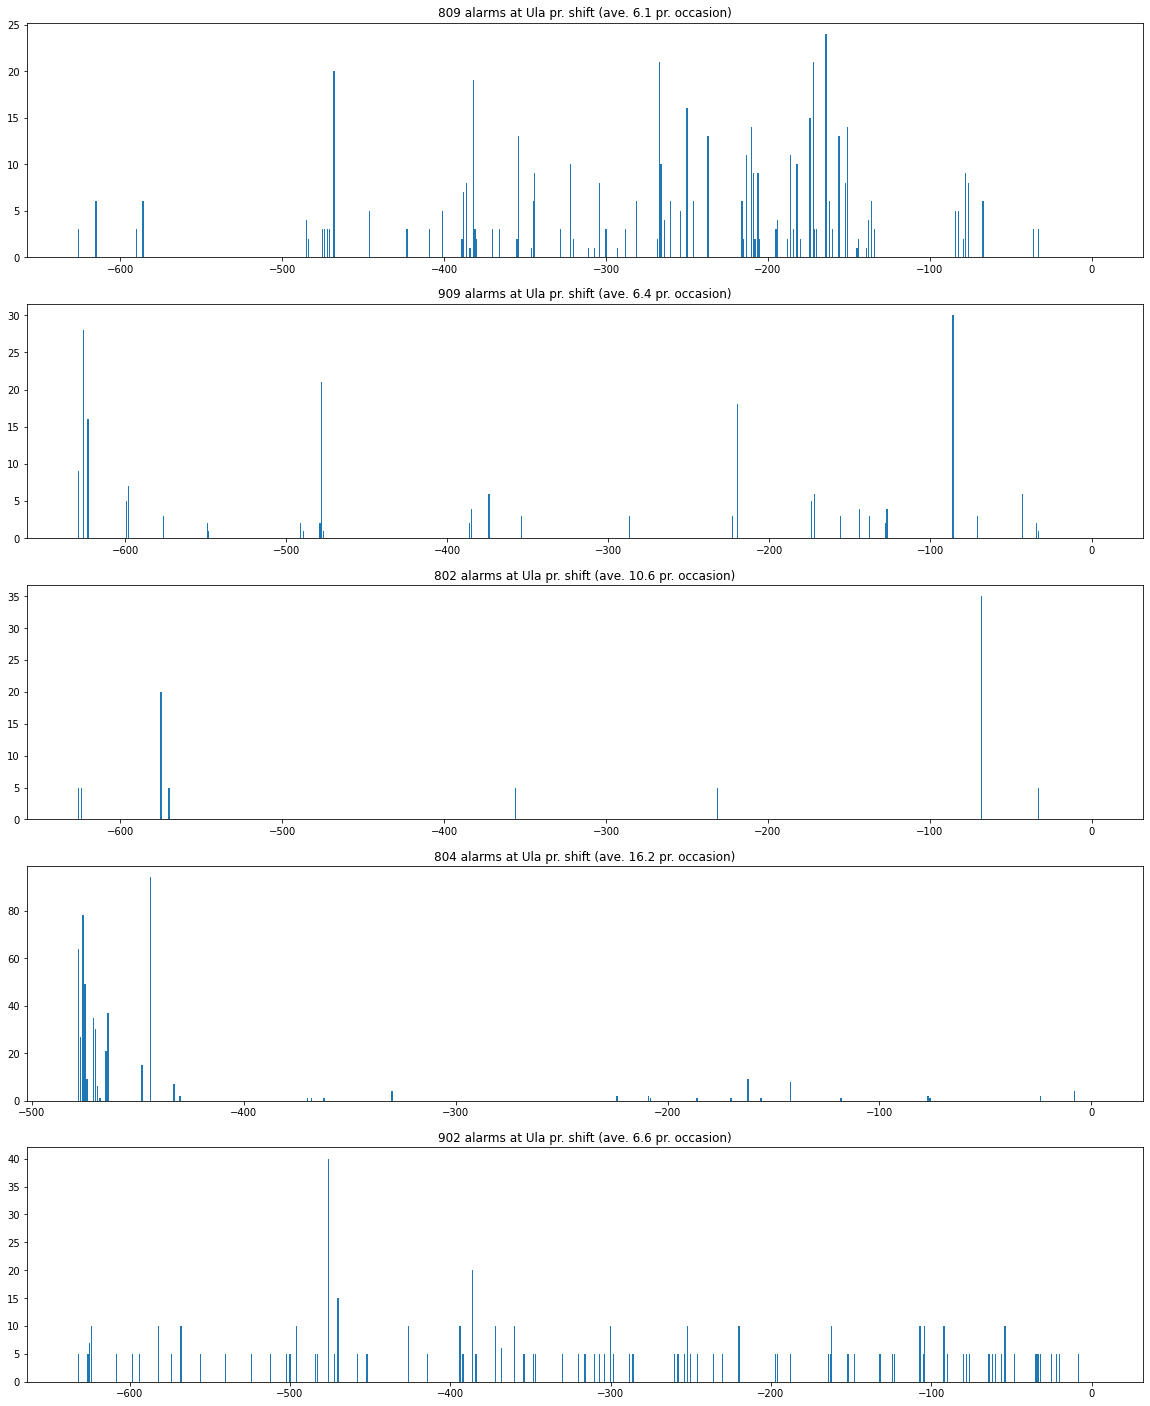

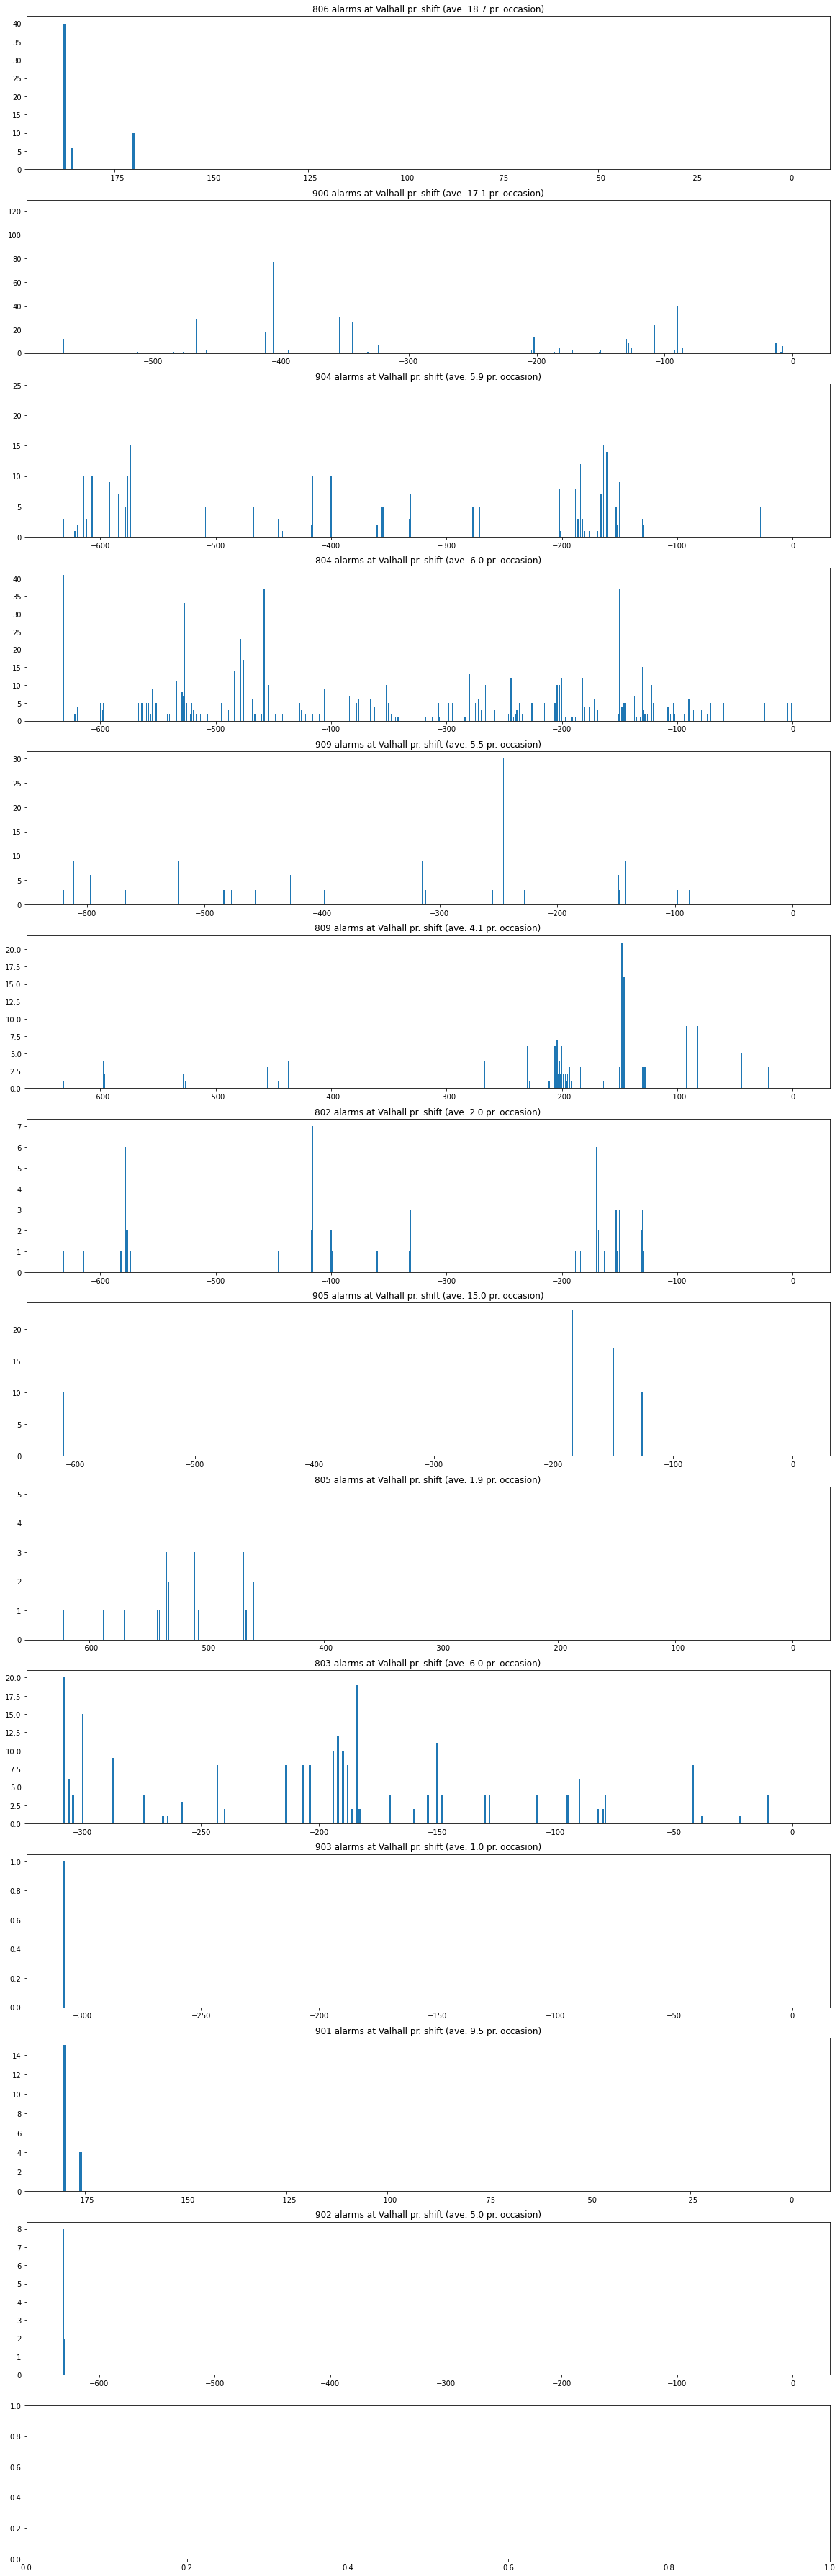

In [26]:
%matplotlib inline
for field, severities in severity_mapping.items():
    fig, axs = plt.subplots(len([sev for sev in severities if int(sev) > 800]), 1, sharex=False)
    fig_index = 0
    for severity, bins in severities.items():
        if int(severity[0]) >= 8:
            total = 0
            occasions = 0
            for b in bins:
                if b > 0:
                    total += b
                    occasions += 1
            axs[fig_index].bar(list(range(0, -len(bins), -1)), bins)
            axs[fig_index].set_title(f'{severity} alarms at {handover.fields[field].name} pr. shift (ave. {total/occasions:.1f} pr. occasion)')
            fig_index += 1
    fig.set_figheight(fig_index*5)
    fig.set_figwidth(20)
    plt.show()

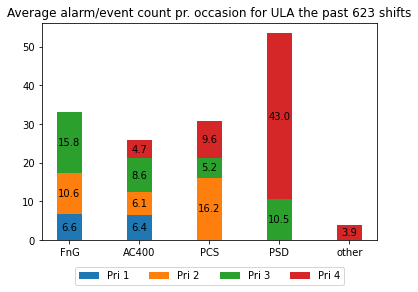

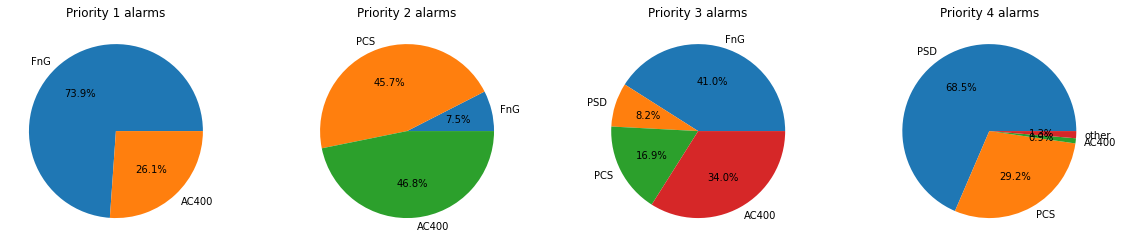

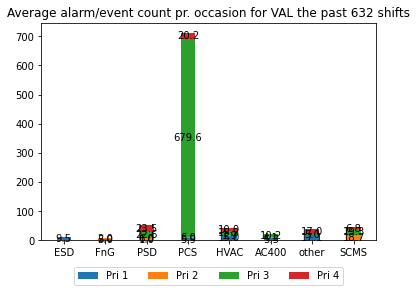

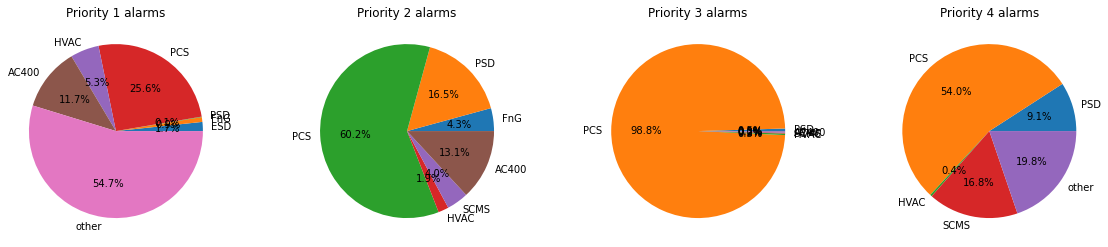

In [27]:
for field, severities in severity_mapping.items():
    alarm_priorities = {
        '9': 'pri1',
        '8': 'pri2',
        '7': 'pri3',
        '6': 'pri4',
        '4': 'event',
        'other': 'other'
    }
    alarm_systems = {
        '01': 'ESD',
        '02': 'FnG',
        '03': 'PSD',
        '04': 'PCS',
        '05': 'HVAC',
        '06': 'SCMS',
        '09': 'AC400',
        'other': 'other'
    }
    mapping = {pri: {sys: 0 for sys in alarm_systems.values()} for pri in alarm_priorities.values()}
    occasions = {pri: {sys: 0 for sys in alarm_systems.values()} for pri in alarm_priorities.values()}

    for severity, bins in severities.items():
        pri = alarm_priorities[severity[0]] if severity[0] in alarm_priorities else 'other'
        sys = alarm_systems[severity[1:]] if severity[1:] in alarm_systems else 'other'

        n_shifts = None
        temp_bins = bins[0:min(len(bins), n_shifts) if n_shifts else len(bins)]
        n_shifts = max(n_shifts, len(temp_bins)) if n_shifts else len(temp_bins)
        for b in temp_bins:
            if b > 0:
                mapping[pri][sys] += b
                occasions[pri][sys] += 1

    matrix = []
    row_headers = [pri for pri in mapping.keys()]
    col_headers = None
    for pri, entries in mapping.items():
        row = []
        if not col_headers: col_headers = [sys for sys in entries.keys()]
        for count in entries.values():
            row.append(count)
        matrix.append(row)

    occasion_matrix = []
    for pri, entries in occasions.items():
        row = []
        if not col_headers: col_headers = [sys for sys in entries.keys()]
        for count in entries.values():
            row.append(count)
        occasion_matrix.append(row)

    width = 0.35
    bottom = [0 for i in range(len(matrix[0]))]
    for i in range(4):
        labels = []
        values = []
        temp = []
        for j in range(len(matrix[i])):
            if matrix[i][j] > 0:
                labels.append(col_headers[j])
                values.append(matrix[i][j]/occasion_matrix[i][j])
                temp.append(bottom[j])
                bottom[j] += matrix[i][j]/occasion_matrix[i][j]
        p = plt.bar(labels, values, width, bottom=temp, label=f'Pri {i+1}')
        plt.bar_label(p, fmt='%.1f', label_type='center')
    plt.title(f'Average alarm/event count pr. occasion for {field} the past {n_shifts} shifts')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=4, shadow=False)
    plt.show()
    
    fig, axs = plt.subplots(1, 4)
    for i, row in enumerate(matrix[0:4]):
        sizes = [num for num in row if num != 0]
        labels = [col_headers[i] for i in range(len(row)) if row[i] != 0]
        axs[i].pie(sizes, labels=labels, autopct='%.1f%%')
        axs[i].set_title(f'Priority {i+1} alarms')
    fig.set_figwidth(20)
    plt.show()

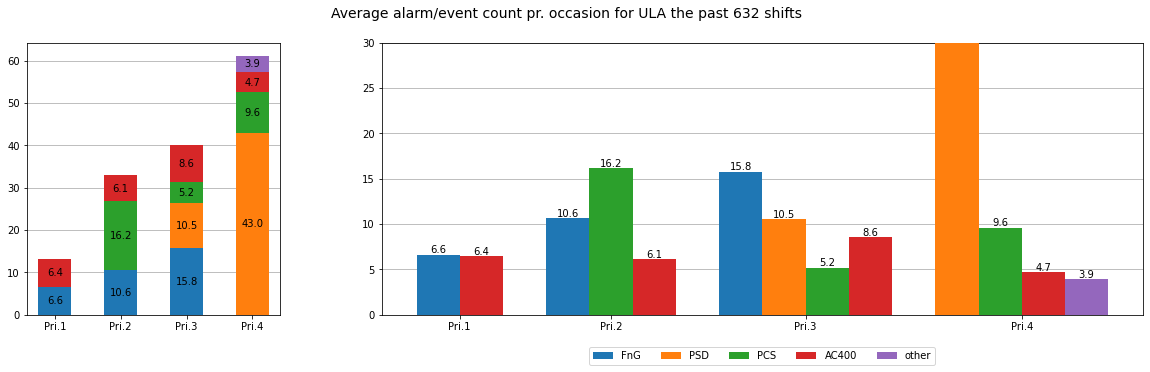

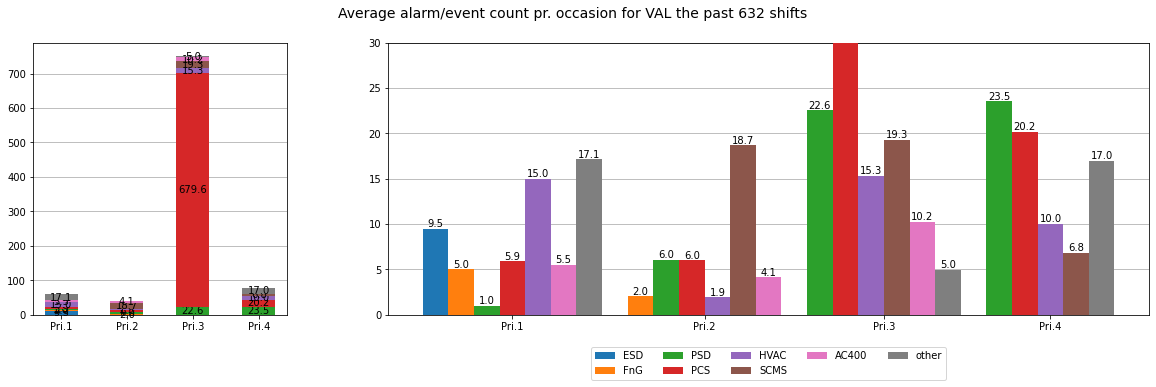

In [28]:
for field, severities in severity_mapping.items():
    severity_dict = {sys: {pri: {'total': 0, 'occasions': 0, 'average': 0} for pri in priorities} for sys in systems[field]}
    
    for severity, bins in severities.items():
        n_events = 0
        count = 0
        for b in bins:
            if b > 0:
                n_events += b
                count += 1
        sys = severity[1:]
        pri = severity[0]
        if sys not in severity_dict: severity_dict[sys] = {priority: {'total': 0, 'occasions': 0, 'average': 0} for priority in severity_dict['01']}
        if pri in severity_dict[sys]:
            severity_dict[sys][pri]['total'] = n_events
            severity_dict[sys][pri]['count'] = count
            severity_dict[sys][pri]['average'] = n_events/count
        else:
            for system in severity_dict:
                severity_dict[system][pri] = {'total': n_events, 'occasions': count, 'average': n_events/count} if system == sys else {'total': 0, 'occasions': 0, 'average': 0}
    mat = []
    for entry in severity_dict.values():
        mat.append([])
        for data in entry.values():
            mat[-1].append(data['average'])
    col_headers = [priorities[key] if key in priorities else f"'{key}'" for key in severity_dict['01']]
    row_headers = [systems[field][key] if key in systems[field] else f"'{key}'" for key in severity_dict]
    
    fig, axs = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios': [1, 3]})
    width = 0.5
    bottom = [0 for i in range(4)]
    for sys, entries in severity_dict.items():
        labels = []
        values = []
        temp = []
        max_value = 1000
        for i, pri in enumerate(entries):
            if entries[pri]['average'] != 0:
                value = entries[pri]['average']
                if value > max_value: 
                    max_value = value
                else:
                    labels.append(priorities[pri])
                    values.append(value)
                    temp.append(bottom[i])
                    bottom[i] += value
            if i >= 3: break
        if labels:
            p = axs[0].bar(labels, values, width, bottom=temp, label=f'{systems[field][sys] if sys in systems[field] else "other"}', zorder=3)
            axs[0].bar_label(p, fmt='%.1f', label_type='center')
    axs[0].yaxis.grid(zorder=1)
    #axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, shadow=False)
    
    width = 0.35
    labels = [pri for pri in priorities.values()]
    labels = labels[:-1]
    n_labels = [0 for _ in range(len(labels))]
    legends = []
    values = []
    for sys, entries in severity_dict.items():
        legends.append(systems[field][sys] if sys in systems[field] else 'other')
        values.append([])
        for i, pri in enumerate(entries):
            if i >= len(labels): break
            values[-1].append(entries[pri]['average'])
            if values[-1][i] != 0:
                n_labels[i] += 1
    x_values = []
    x_centres = [0]
    for i in range(len(n_labels)-1):
        x_centres.append(x_centres[i] + (n_labels[i] + n_labels[i+1] + 2)*width/2)
    fig_width = 0
    for i, n in enumerate(n_labels):
        x_values.append(np.linspace(x_centres[i] + (1-n)*width/2, x_centres[i] + (n-1)*width/2, n))
        fig_width += n
    #fig.set_figwidth(fig_width)
    for i, row in enumerate(values):
        x = []
        y = []
        for j in range(len(row)):
            if row[j] != 0:
                x.append(x_values[j][0])
                x_values[j] = x_values[j][1:]
                y.append(row[j])
        if x:
            p = axs[1].bar(x, y, width, label=legends[i], zorder=3)
            axs[1].bar_label(p, fmt='%.1f')
    axs[1].set_xticks(x_centres, labels)
    axs[1].set_ylim(0, 30)
    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, shadow=False)
    axs[1].yaxis.grid(zorder=1)
    
    fig.suptitle(f'Average alarm/event count pr. occasion for {field} the past {n_shifts} shifts', fontsize=14)
    plt.show()

#### Check if assets outside of the OPC UA dataset has OPC UA events
Hardcoded section to find the rest of the assets outside of the OPC UA datasets, so that we can check if they can have events from the OPC UA datasets related to them, even though the source of the asset  (typically) is aveva:

In [16]:
possible_assets = {}
for field in handover.fields.values():
    possible_assets[field.abbr()] = []
    n_comp = 0
    count = 0
    event_count = 0
    for comp in field.main_components:
        #if not comp.assets:
        if not comp.exact_match:
            n_comp += 1
            assets = client.assets.list(name=comp.name)
            if assets:
                count += 1
                asset_list = []
                for asset in assets:
                    if re.search(f'^{comp.name}', asset.name):
                        if field.abbr() == 'VAL':
                            if asset.external_id[0:3] in ['VAL', 'VLA', 'VFS', 'VFN', 'VFW', 'TAM', 'HOP', 'HOD']:
                                asset_list.append(asset)
                        elif field.abbr() == 'ULA':
                            if asset.external_id[0:3] in ['ULA', 'TAM']:
                                asset_list.append(asset)
                        else:
                            if field.abbr() == asset.external_id[0:3]:
                                asset_list.append(asset)
                if len(asset_list) > 1:
                    print('found multiple assets')
                    for asset in asset_list:
                        print(asset.external_id)
                        if not re.search(f'^{comp.name}', asset.name):
                            asset_list.remove(asset)
                if asset_list:
                    possible_assets[field.abbr()].append(asset_list[0])
                    if handover.fields[field.abbr()].data_set_id:
                        datasets = [handover.fields[field.abbr()].data_set_id]
                        #datasets.extend([1525574569706251, 3874712032478167])
                        event_count += len(asset_list[0].events(data_set_ids=datasets, limit=-1))
            #else:
            #    print(f'Could not find any asset with the name {comp.name} on {field.name}')
    print(f'Found {count} out of {n_comp} of the other main component tags outside the OPC UA datasets on {field.name}')
    print(f'These tags had {event_count} OPC UA events related to them')

Found 232 out of 233 of the other main component tags outside the OPC UA datasets on Alvheim
These tags had 0 OPC UA events related to them
Found 71 out of 71 of the other main component tags outside the OPC UA datasets on Ivar Aasen
These tags had 0 OPC UA events related to them
Found 501 out of 517 of the other main component tags outside the OPC UA datasets on Skarv
These tags had 0 OPC UA events related to them
found multiple assets
TAM_CR-19101
ULA_CR-19101
Found 137 out of 137 of the other main component tags outside the OPC UA datasets on Ula
These tags had 0 OPC UA events related to them
Found 427 out of 432 of the other main component tags outside the OPC UA datasets on Valhall
These tags had 0 OPC UA events related to them


Looping through shifts in reverse chronological order until it finds a shift where there are logged events on the relevant assets:

In [17]:
today = datetime.datetime.today()
date = today - datetime.timedelta(days=19)    # Start search before TAR the 25th/26th (Ula/Valhall) of May
t2 = 0
t1 = 0

for field, comps in handover.main_components.items():
    global t1, t2
    t2 = datetime.datetime(date.year, date.month, date.day, 19)
    t1 = t2 - datetime.timedelta(hours=12)
    found = False
    shifts_ago = 0
    n_events = 0
    while not found:
        print(t1)
        for comp in comps:
            for asset in comp.assets:
                temp = asset.parent.events(data_set_ids=[handover.fields[field].data_set_id], last_updated_time={"min": timestamp_to_ms(t1), "max": timestamp_to_ms(t2)}, sort=['lastUpdatedTime:asc'], limit=-1)
                if temp:
                    found = True
                    asset.events = temp
                    n_events += len(temp)
        if not found:
            t1 -= datetime.timedelta(hours=12)
            t2 -= datetime.timedelta(hours=12)
            shifts_ago += 1
    print(f'Found {n_events} events at {handover.fields[field].name} {shifts_ago} shifts ago, between {t1} and {t2}.')
    #break

2022-05-25 07:00:00
2022-05-24 19:00:00
2022-05-24 07:00:00
Found 26 events at Ula 2 shifts ago, between 2022-05-24 07:00:00 and 2022-05-24 19:00:00.
2022-05-25 07:00:00
Found 3078 events at Valhall 0 shifts ago, between 2022-05-25 07:00:00 and 2022-05-25 19:00:00.


In [14]:
handover.main_components['ULA'][7].assets[0].parent.events(data_set_ids=[handover.fields['ULA'].data_set_id], last_updated_time={"min": timestamp_to_ms(t1), "max": timestamp_to_ms(t2)}, sort=['lastUpdatedTime:asc'], limit=-1)

NameError: name 't1' is not defined

In [21]:
for field, comps in handover.main_components.items():
    print(f'\n\nEvents from {handover.fields[field].name}:')
    severity_count = [0, 0, 0, 0, 0, 0]
    for comp in comps:
        for asset in comp.assets:
            if asset.events:
                for event in asset.events:
                    severity = event.metadata['severity']
                    if "90" in severity:
                        print(severity)
                        severity_count[0] += 1
                    elif "80" in severity:
                        severity_count[1] += 1
                    elif "70" in severity:
                        severity_count[2] += 1
                    elif "60" in severity:
                        severity_count[3] += 1
                    elif "40" in severity:
                        severity_count[4] += 1
                    else:
                        severity_count[5] += 1
    print(f'Priority 1: {severity_count[0]}\nPriority 2: {severity_count[1]}\nPriority 3: {severity_count[2]}\nPriority 4: {severity_count[3]}\nEvents: {severity_count[4]}\nOther: {severity_count[5]}')



Events from Ula:
Priority 1: 0
Priority 2: 0
Priority 3: 5
Priority 4: 0
Events: 18
Other: 3


Events from Valhall:
909
909
909
Priority 1: 3
Priority 2: 1
Priority 3: 797
Priority 4: 0
Events: 2218
Other: 59


In [19]:
for field, comps in handover.main_components.items():
    print(f'\n\nEvents from {handover.fields[field].name}:')
    for comp in comps:
        comp_title = False
        for asset in comp.assets:
            if asset.events:
                if not comp_title: 
                    print(f'\n\n{comp.name} ({comp.description}):')
                    comp_title = True
                print(f'\n{asset.name} ({len(asset.events)} events):')
                for event in asset.events:
                    print(f'{ms_to_datetime(event.last_updated_time).strftime("%Y-%m-%d %H:%M:%S")} ({event.metadata["severity"]}) {event.description}')



Events from Ula:


Z-0501 (Fire Pump (P)):

CAP_Z-0501_CA (2 events):
2022-05-24 15:13:13 (402) Abnormal condition
2022-05-24 17:14:12 (402) Normal state

Z-0501-02 (6 events):
2022-05-24 16:13:37 (702) Alarm HH
2022-05-24 16:13:47 (200) Acknowledge of High High condition on object Z-0501-02 has been requested.
2022-05-24 16:13:56 (702) Alarm HH
2022-05-24 16:14:14 (702) Alarm HH
2022-05-24 17:14:03 (702) Alarm HH off
2022-05-24 17:14:10 (702) Alarm HH

CAP_Z-0501_UA (2 events):
2022-05-24 15:13:07 (402) Abnormal condition
2022-05-24 17:13:56 (402) Normal state

CAP_Z-0501_RUN (2 events):
2022-05-24 16:14:22 (402) Abnormal condition
2022-05-24 17:14:03 (402) Normal state


P-01102-A (LP Electrical Pump):

P-01102-A (7 events):
2022-05-24 12:10:34 (409) Off
2022-05-24 12:10:44 (409) On
2022-05-24 12:10:52 (409) Off
2022-05-24 15:12:32 (409) On
2022-05-24 15:12:40 (200) MORD_04  -> True 
2022-05-24 15:12:46 (409) On
2022-05-24 15:13:13 (409) Off


P-01102-B (LP Electrical Pump):

P-011

In [24]:
print(handover.assets['ULA'][0])
print(events['ULA']['P-01102-B'][0])

{
    "external_id": "opcua_ula_eo:s=8e9dfb7e-a8c4-4270-97ab-6eff4b96ed92",
    "name": "PSD_Gas_Cooler_E-0164",
    "parent_id": 8559604924045875,
    "parent_external_id": "ULA_E-0164",
    "description": "",
    "data_set_id": 2086908079872503,
    "metadata": {
        "Description": "",
        "Id": "8e9dfb7e-a8c4-4270-97ab-6eff4b96ed92",
        "Name": "PSD_Gas_Cooler_E-0164",
        "TypeDefinition": "EdgeObjectType",
        "TypeId": "Level:LB",
        "Version": "2.0.0",
        "contextAgent": "ULA OPCUA Pipeline",
        "contextAlgorithm": "regex_match",
        "contextConfidenceScore": "1.0",
        "dataSetExternalId": "dataset:opcua_data_ula",
        "externalId": "opcua_ula_eo:s=8e9dfb7e-a8c4-4270-97ab-6eff4b96ed92",
        "labels": "label:ula-opc-ua",
        "location": "ULA",
        "name": "PSD_Gas_Cooler_E-0164",
        "parentExternalId": "ULA_E-0164",
        "source": "OPC_UA"
    },
    "source": "OPC_UA",
    "labels": [
        {
            "ext